# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [68]:
# Import numpy and pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

plt.rcParams['figure.figsize'] = (20,12)

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
# Your code here:
sensor.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [7]:
# Your code here:
print(f'Rows: {sensor.shape[0]}\tColumns: {sensor.shape[1]}')

Rows: 1751	Columns: 12


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [13]:
# Your code here:
date_range = pd.date_range(start='1/1/2018 00:00:00', end='1/1/2018 00:29:10', periods=1751)

Assign the time series index to the dataframe's index.

In [15]:
# Your code here:
sensor.index = date_range

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [17]:
# Your code here:
import statsmodels.api as sm

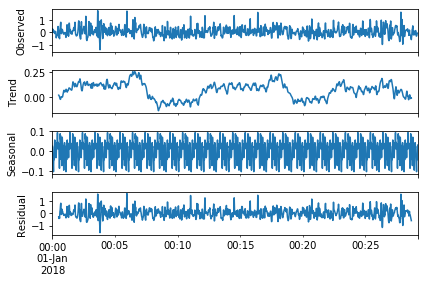

In [28]:
response = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], freq=60)
response.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

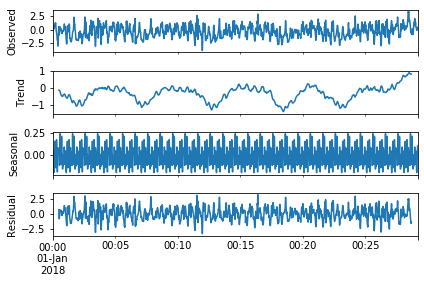

In [27]:
response = sm.tsa.seasonal_decompose(sensor['rotationRate.x'], freq=60)
response.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

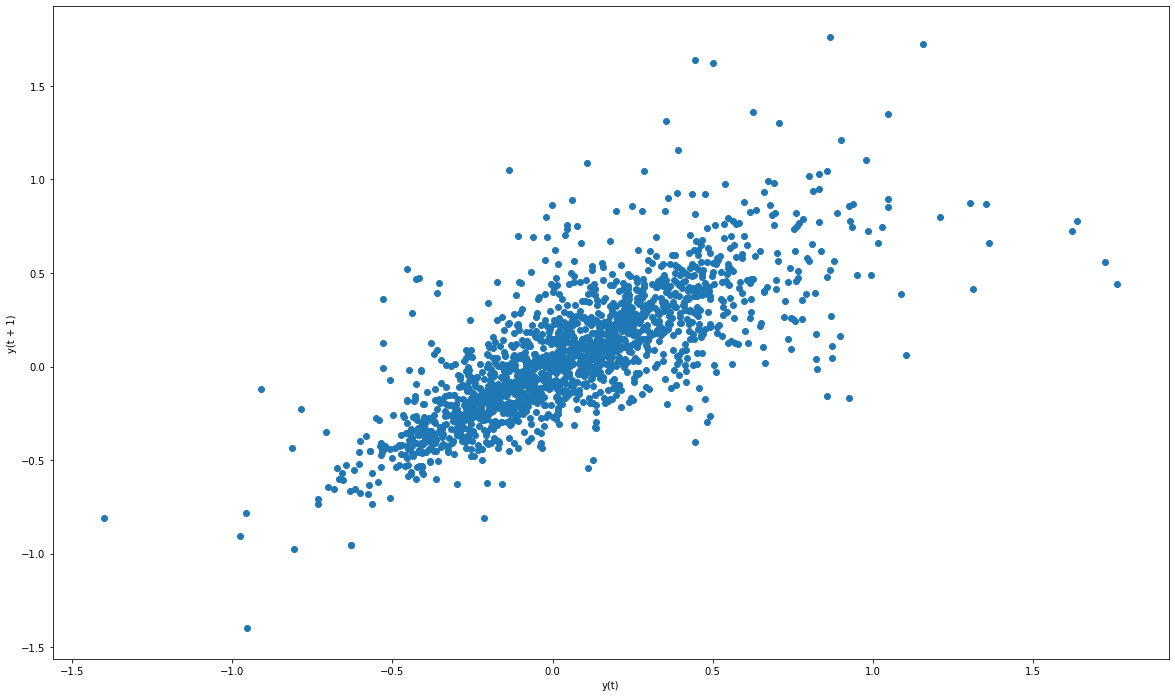

In [32]:
# Your code here:
lag_plot(sensor['userAcceleration.x']);

Create a lag plot for `rotationRate.x`

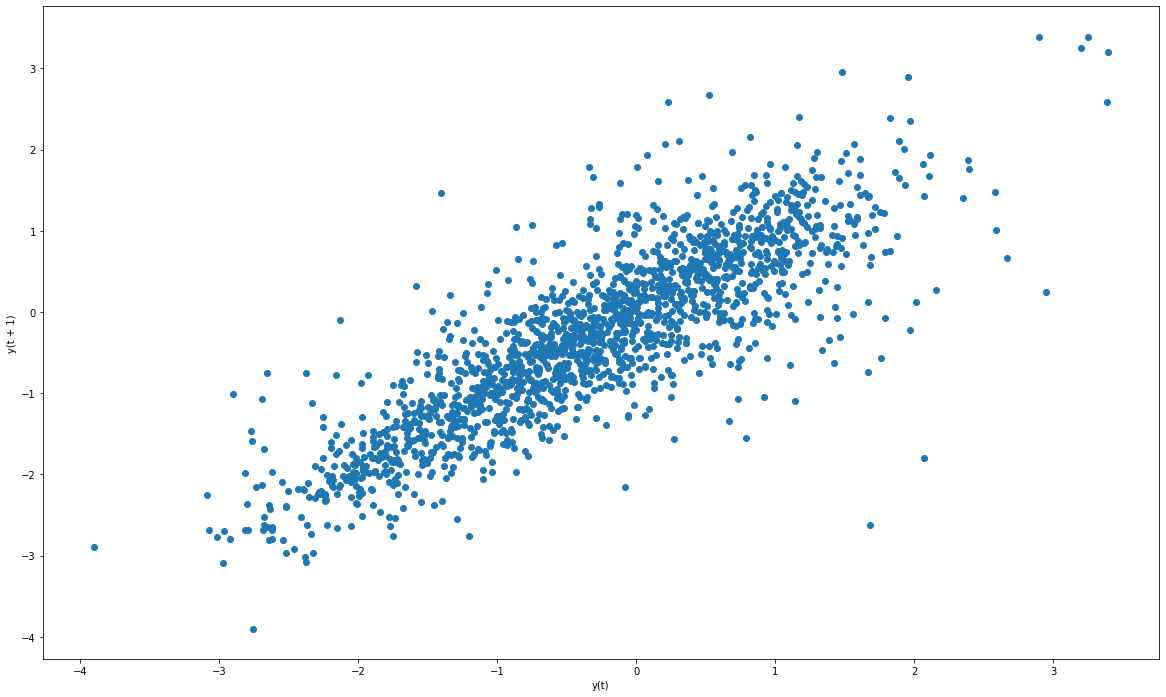

In [33]:
# Your code here:

lag_plot(sensor['rotationRate.x']);

What are your conclusions from both visualizations?

In [11]:
# Your conclusions here:
# There is a slight autocorrelation in both variables, however it cannot be taken as a good estimator due to the amount 
# of variance shown in both plots. 

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [42]:
# Your code here:
ua_x, rr_x = adfuller(sensor['userAcceleration.x'])[1], adfuller(sensor['rotationRate.x'])[1]

In [44]:
print(f'userAcceleration.x p-value: {ua_x}\nrotationRate.x p-value: {rr_x}')

userAcceleration.x p-value: 2.823439483037483e-30
rotationRate.x p-value: 6.320230335912605e-06


What are your conclusions from this test?

In [13]:
# Your conclusions here:
# Both variables have a p-value less than 0.05, thus it can be concluded that the data is stationary.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [56]:
# Your code here:
model = ARMA(sensor['userAcceleration.x'][:-10], order=(2, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(-10,-1)

/home/xhoan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


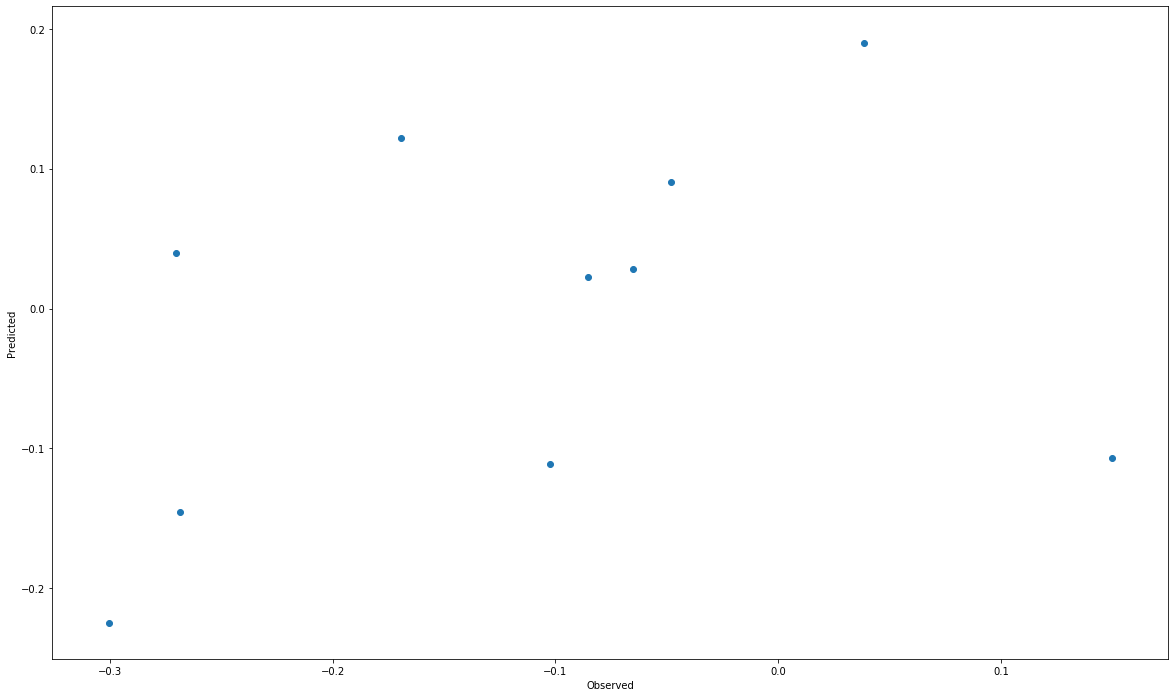

In [65]:
plt.scatter(sensor['userAcceleration.x'][-10:], predictions)
plt.xlabel('Observed')
plt.ylabel('Predicted');

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [72]:
# Your code here:
rmse(sensor['userAcceleration.x'][-10:], predictions)

0.18177171903973283